In [1]:
import h5py
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

from neuropacks import ECOG
from uoineuro.utils import plot_metric_summary

%matplotlib inline

In [2]:
data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')

In [ ]:
data_path = '/storage/data/ecog/r32_b7.mat'
grid_path = '/storage/data/ecog/grdid.mat'

In [3]:
fits_path = os.path.join(os.environ['HOME'],
                         'fits/uoineuro/coupling/ecog/ecog_coupling.h5')

In [4]:
ecog = ECOG(data_path=data_path, grid_path=grid_path)
fits = h5py.File(fits_path, 'r')

In [5]:
baseline = fits['lasso']
algorithms = [fits['uoi_lasso_r2'], fits['uoi_lasso_aic'], fits['uoi_lasso_bic']]

# Metric Comparison

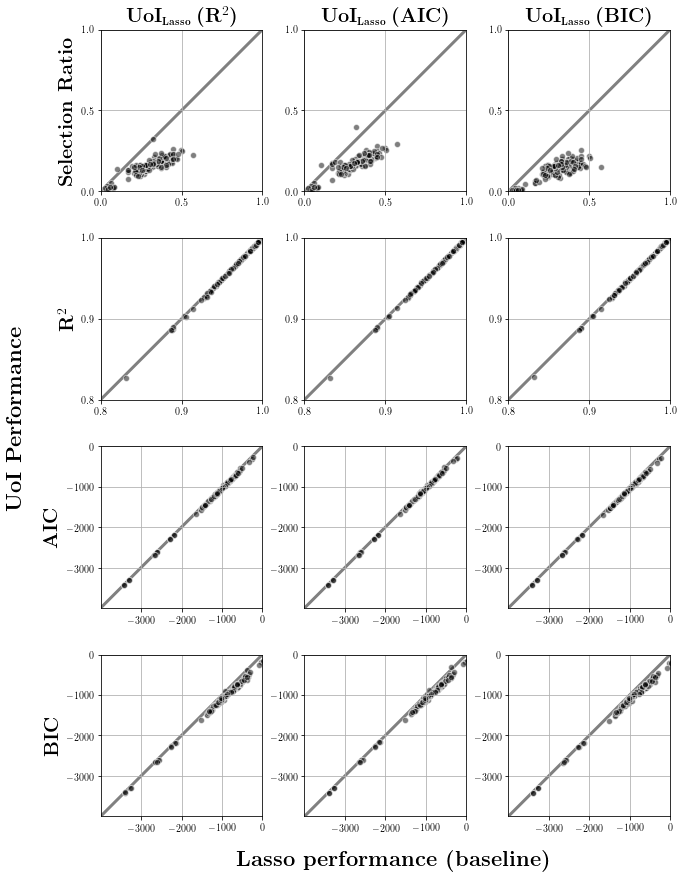

In [6]:
fig, axes = plot_metric_summary(baseline_group=baseline,
                                fits_groups=algorithms,
                                metrics=['selection_ratio', 'r2', 'AIC', 'BIC'])

# additional customizations 

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([0.80, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0.8, 0.9, 1])
    ax.set_yticks([0.8, 0.9, 1])
    ax.grid('on')

# third row: AIC
for idx in range(3):
    ax = axes[2, idx]
    ax.set_xlim([-4000, 0])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([-3000, -2000, -1000, 0])
    ax.set_yticks([-3000, -2000, -1000, 0])
    ax.grid('on')
    
# third row: BIC
for idx in range(3):
    ax = axes[3, idx]
    ax.set_xlim([-4000, 0])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([-3000, -2000, -1000, 0])
    ax.set_yticks([-3000, -2000, -1000, 0])
    ax.grid('on')
    
for ax in axes.ravel():
    ax.tick_params(labelsize=10)
    
axes[0, 0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=20)
axes[1, 0].set_ylabel(r'$\mathbf{R}^2$', fontsize=20)
axes[2, 0].set_ylabel(r'\textbf{AIC}', fontsize=20)
axes[3, 0].set_ylabel(r'\textbf{BIC}', fontsize=20)

axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(BIC)}',
                     fontsize=20)
fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{Lasso performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{UoI Performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()

# plt.savefig('ecog_coupling_metric_summary.pdf', bbox_inches='tight')

# Graph Comparison

In [7]:
uoi_coupling_coefs = np.zeros((ecog.n_electrodes, ecog.n_electrodes))
lasso_coupling_coefs = np.zeros((ecog.n_electrodes, ecog.n_electrodes))

In [8]:
lasso_median_coefs = np.median(fits['lasso/coupling_coefs'], axis=0)
uoi_median_coefs = np.median(fits['uoi_lasso_bic/coupling_coefs'], axis=0)

In [9]:
for electrode in range(ecog.n_electrodes):
    lasso_coupling_coefs[electrode] = np.insert(lasso_median_coefs[electrode], electrode, 0)
    uoi_coupling_coefs[electrode] = np.insert(uoi_median_coefs[electrode], electrode, 0) 

In [10]:
G_lasso = nx.Graph()
G_uoi = nx.Graph()

In [11]:
# add nodes
positions = {}

for electrode in range(ecog.n_electrodes):
    G_lasso.add_node(electrode)
    G_uoi.add_node(electrode)
    x, y = ecog.get_xy_for_electrode(electrode)
    positions[electrode] = (y, -x)

In [12]:
weights_lasso = {}
weights_uoi = {}

for electrode_pair in itertools.combinations(np.arange(ecog.n_electrodes), 2):
    e1, e2 = electrode_pair
    weight = 0.5 * (lasso_coupling_coefs[e1, e2] + lasso_coupling_coefs[e2, e1])
    if weight != 0:
        weights_lasso[electrode_pair] = np.sign(weight) * np.sqrt(np.abs(weight))
        G_lasso.add_weighted_edges_from([(e1, e2, weight)])

    weight = 0.5 * (uoi_coupling_coefs[e1, e2] + uoi_coupling_coefs[e2, e1])
    if weight != 0:
        weights_uoi[electrode_pair] = np.sign(weight) * np.sqrt(np.abs(weight))
        G_uoi.add_weighted_edges_from([(e1, e2, weight)])

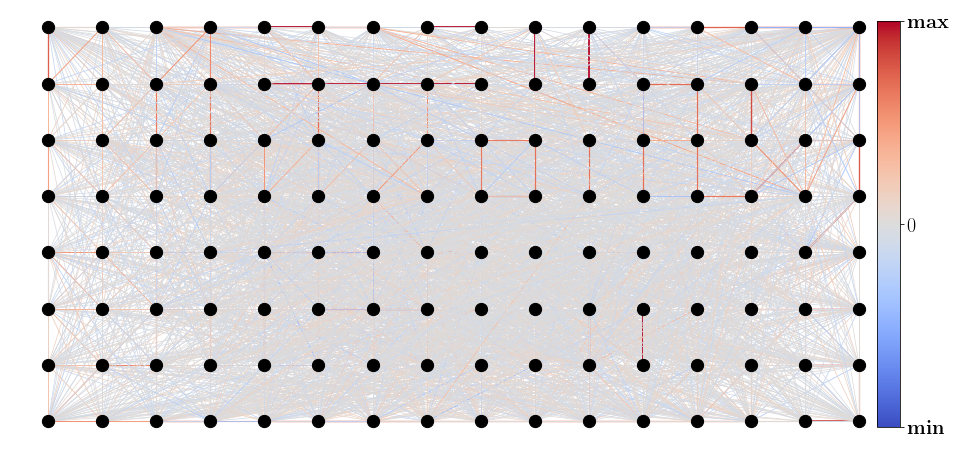

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

nx.draw_networkx_nodes(
    G=G_lasso,
    pos=positions,
    node_size=150,
    node_color='k',
    ax=ax)

nx.draw_networkx_edges(
    G=G_lasso,
    pos=positions,
    width=0.75 + np.abs(list(weights_lasso.values()))**2,
    edge_color=list(weights_lasso.values()),
    edge_cmap=plt.get_cmap('coolwarm'),
    edge_vmin=-1,
    edge_vmax=1)

sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('coolwarm'),
                           norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []

cax = fig.add_axes([0.88, 0.15, 0.02, 0.705])
cb = fig.colorbar(sm, cax=cax, orientation='vertical')
cb.set_ticks([-1, 0, 1])
cb.set_ticklabels([r'\textbf{min}', 0, r'\textbf{max}'])
cb.ax.tick_params(labelsize=20)
ax.axis('off')
plt.savefig('ecog_grid_lasso.pdf', bbox_inches='tight')

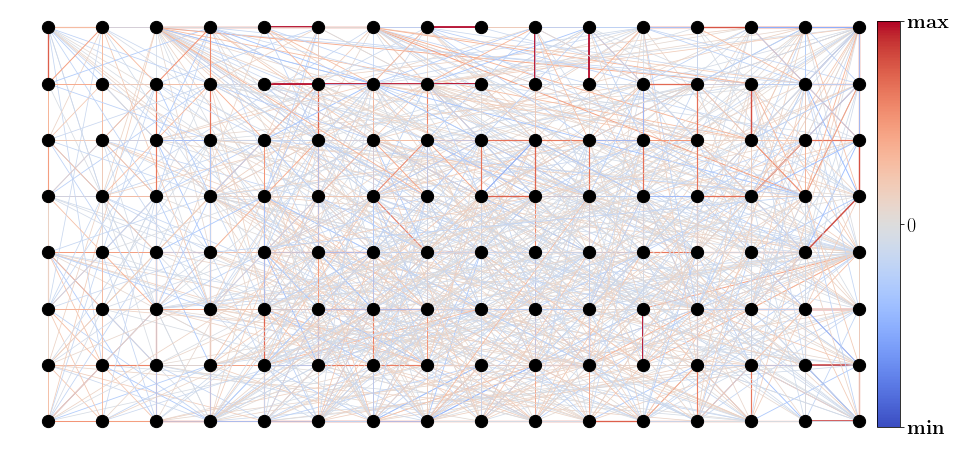

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

nx.draw_networkx_nodes(
    G=G_uoi,
    pos=positions,
    node_size=150,
    node_color='k',
    ax=ax
)

nx.draw_networkx_edges(
    G=G_uoi,
    pos=positions,
    width=0.75 + np.abs(list(weights_uoi.values()))**2,
    edge_color=list(weights_uoi.values()),
    edge_cmap=plt.get_cmap('coolwarm'),
    edge_vmin=-1,
    edge_vmax=1
)

sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('coolwarm'),
                           norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []

cax = fig.add_axes([0.88, 0.15, 0.02, 0.705])
cb = fig.colorbar(sm, cax=cax, orientation='vertical')
cb.set_ticks([-1, 0, 1])
cb.set_ticklabels([r'\textbf{min}',0,  r'\textbf{max}'])
cb.ax.tick_params(labelsize=20)
ax.axis('off')
plt.savefig('ecog_grid_uoi.pdf', bbox_inches='tight')